In [103]:
# import packages
import warnings
from tqdm import tqdm
from sklearn.metrics import roc_curve
import skimage
from skimage.filters import try_all_threshold, threshold_otsu
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine, euclidean, cdist
import os
import requests
import sys
import random
import itertools
from typing import Tuple
from PIL import Image, ImageDraw, ImageFont
import cv2
import string

In [104]:
BACKGROUNDS_PATH = "data/backgrounds"
AR_WORDSLIST_PATH = "data/arabic_names.txt"
FONTS_PATH = "data/fonts/arabic_fonts"
OUTPUT_PATH = "Datasets/ARABIC/Synthetic_Rec_Ar_V7"
OCR_MODEL_INPUT_SHAPE = (416, 30)
MAX_NUM_WORDS = 7
PUNCTUATIONS = ['(', ')', '-', '.', '،', '؟', 'ء']
# CHARS_TO_IGNORE  = ['↑', '↓', '…', '\u200b', 'ٍ', 'ٍ', 'َ', 'ُ', 'ّ', 'ً', '«', '؛', '“']
CHARS_TO_IGNORE  = ['\u0660', '\u0661', '\u0662', '\u0663', '\u0664', '\ufb6c', '\ufe85', '\ufe80']

print("Chars to Ignore:")
for char in CHARS_TO_IGNORE:
    print(f"{char}: {ascii(char)}")
print()

OUTPUT_TRAIN_PATH = os.path.join(OUTPUT_PATH, "train")
OUTPUT_TEST_PATH = os.path.join(OUTPUT_PATH, "test")
os.makedirs(OUTPUT_TRAIN_PATH, exist_ok=True)
os.makedirs(OUTPUT_TEST_PATH, exist_ok=True)

BACKGROUNDS = []
for bg_name in os.listdir(BACKGROUNDS_PATH):
    basename, ext = os.path.splitext(bg_name)
    if ext in [".jpg", ".png"]:
        BACKGROUNDS.append(os.path.join(BACKGROUNDS_PATH, bg_name))
print("Total backgrounds found:", len(BACKGROUNDS))

chars_mapping_ = {
    '\u0622': ['\ufe82', '\ufe81'],
    '\u0623': ['\ufe84', '\ufe83'],
    '\u0627': ['\ufe87', '\ufe8e', '\ufe8d', '\ufe84', '\ufe83'],
    '\u0628': ['\ufe90', '\ufe91', '\ufe92', '\ufe8f'],    
    '\u062a': ['\ufe96', '\ufe97', '\ufe95', '\ufe97', '\ufe98'],
    '\u0629': ['\ufe93', '\ufe94'],
    '\u062b': ['\ufe9a', '\ufe99', '\ufe9b', '\ufe9c'],
    '\u062c': ['\ufea0', '\ufe9e', '\ufe9d', '\ufe9f'],
    '\u062d': ['\ufea1', '\ufea2', '\ufea3', '\ufea4'],
    '\u062e': ['\ufea5', '\ufea6', '\ufea7', '\ufea8'],
    '\u062f': ['\ufe8b', '\ufe8c', '\ufbe8', '\ufeaa', '\ufea9'],
    '\u0630': ['\ufeab', '\ufeac'],
    '\u0631': ['\ufeae', '\ufead'],
    '\u0632': ['\ufeb0', '\ufeaf'],
    '\u0633': ['\ufeb1', '\ufeb2', '\ufeb3', '\ufeb4'],
    '\u0634': ['\ufeb5', '\ufeb6', '\ufeb7', '\ufeb8'],
    '\u0635': ['\ufeba', '\ufeb9', '\ufebb', '\ufebc'],
    '\u0636': ['\ufebe', '\ufebd', '\ufec0', '\ufebf'],
    '\u0637': ['\ufec2', '\ufec3', '\ufec4', '\ufec1'],
    '\u0638': ['\ufec6', '\ufec7', '\ufec8', '\ufec5'],
    '\u0639': ['\ufec9', '\ufeca', '\ufecb', '\ufecc'],
    '\u063a': ['\ufecd', '\ufece', '\ufecf', '\ufed0'],
    '\u0641': ['\ufed1', '\ufed2', '\ufed3', '\ufed4'],
    '\u0642': ['\ufed5', '\ufed6', '\ufed7', '\ufed8'],
    '\u0643': ['\ufed9', '\ufeda', '\ufedb', '\ufedc'],
    '\u0644': ['\ufede', '\ufedd', '\ufedf', '\ufee0'],
    '\u0645': ['\ufee1', '\ufee2', '\ufee3', '\ufee4'],
    '\u0646': ['\ufee5', '\ufee6', '\ufee7', '\ufee8'],
    '\u0647': ['\ufee9', '\ufeea', '\ufeeb', '\ufeec', '\u0665'],
    '\u0648': ['\ufeed', '\ufe85', '\ufeee', '\u0624', '\ufe86', '\ufe85'],
    '\u064a': ['\ufeef', '\ufef3', '\ufef4', '\ufbfc', '\ufe89', '\ufef0', '\ufef1', '\ufef2'],
    '\u0644' + '\u0627': ['\ufef5', '\ufef7', '\ufef9', '\ufefb', '\ufefc'],
}

chars_mapping = {}
for k, v in chars_mapping_.items():
    if k == '':
        continue
    for item in v:
        chars_mapping[item] = k
        
WORDS = []
with open(AR_WORDSLIST_PATH, "r", encoding="utf-8") as reader:
    for w in tqdm(reader.readlines()):
        w = w.strip()
        toIgnore = False
        for char in w:
            if char in string.digits or char in string.ascii_letters or char in CHARS_TO_IGNORE:
                toIgnore = True
        if toIgnore:
            continue
            
        # replace similar chars with others
        for char_2_map, map_char in chars_mapping.items():
            w = w.replace(char_2_map, map_char)
        WORDS.append(w)

dict_list = []
for word in WORDS:
    for char in word:
        if char not in dict_list:
            dict_list.append(char)
dict_list = sorted(dict_list)

# generate more random words
to_gen = 0
for _ in range(to_gen):
    KICKING_CHARS = sorted(['\u0622', '\u0627', '\u062f', '\u0630', '\u0631', '\u0632', '\u0648'])   # ['آ', 'ا', 'د', 'ذ', 'ر', 'ز', 'و']
    JOINING_CHARS = sorted(list(set(dict_list) - set(KICKING_CHARS)))
    JOINING_CHARS.remove('\ufdf2')  # remove 'ﷲ'
    JOINING_CHARS.remove('\u0629')  # remove 'ة' as it only can come in the end.
    w = ''.join(random.choices(JOINING_CHARS, k=random.randint(3, 8)))
    if random.random() > 0.6:
        w = random.choice(KICKING_CHARS) + w
    if random.random() > 0.6:
        w = w + random.choice(KICKING_CHARS)
    if random.random() > 0.8:
        w = w + '\u0629'    # add 'ة' as it only can come in the end.
    WORDS.append(w)

for _ in range(5000):
    WORDS.append('ﷲ')
    
print("Number of Total Words:", len(WORDS))
print()
for char in dict_list:
    print(char, ascii(char))

# list of font types to exclude
FONTS_LIST = []
FONTS_WEIGHTS = []
for path, subdirs, files in os.walk(FONTS_PATH):
    for name in files:
        font_path = os.path.join(path, name)
        basepath, ext = os.path.splitext(font_path)
        if ext != ".Identifier":
            if "Amiri" in font_path:
                FONTS_WEIGHTS.append(5)
            else:
                FONTS_WEIGHTS.append(1)
            FONTS_LIST.append(font_path)

Chars to Ignore:
٠: '\u0660'
١: '\u0661'
٢: '\u0662'
٣: '\u0663'
٤: '\u0664'
ﭬ: '\ufb6c'
ﺅ: '\ufe85'
ﺀ: '\ufe80'

Total backgrounds found: 101


100%|███████████████████████████████████████████████████████████| 104192/104192 [00:00<00:00, 140090.07it/s]

Number of Total Words: 108784

آ '\u0622'
ا '\u0627'
ب '\u0628'
ة '\u0629'
ت '\u062a'
ث '\u062b'
ج '\u062c'
ح '\u062d'
خ '\u062e'
د '\u062f'
ذ '\u0630'
ر '\u0631'
ز '\u0632'
س '\u0633'
ش '\u0634'
ص '\u0635'
ض '\u0636'
ط '\u0637'
ظ '\u0638'
ع '\u0639'
غ '\u063a'
ف '\u0641'
ق '\u0642'
ك '\u0643'
ل '\u0644'
م '\u0645'
ن '\u0646'
ه '\u0647'
و '\u0648'
ي '\u064a'
ﷲ '\ufdf2'


In [105]:
from random import randint
import string
from PIL import ImageOps, ImageChops, ImageFilter, ImageEnhance
from datetime import datetime, timedelta
import arabic_reshaper
from bidi.algorithm import get_display


def resizeAndPadImage(img):
    input_width, input_height = OCR_MODEL_INPUT_SHAPE[:2]
    h, w, c = img.shape
    ratio = w / h
    resized_w = int(input_height * ratio)
    # Resize the width if it exceeds the input width
    isBottomPad = False
    resized_h = input_height
    if resized_w > input_width:
        resized_w = input_width
        resized_h = int(h / w * input_width)
        isBottomPad = True
    # Resize image while preserving aspect ratio
    img = cv2.resize(img, (resized_w, resized_h), interpolation=cv2.INTER_AREA)
    # Prepare target tensor with appropriate dimensions
    target = np.zeros((input_height, input_width, 3), dtype=np.uint8)
    # Place the resized image into the target tensor
    if isBottomPad:
        target[:resized_h, :, :] = img
    else:
        target[:, :resized_w, :] = img
    return target


def get_pil_font(font_list, font_weights, font_size=22):
    # Randomly select a font from a list of common fonts
    font_path = random.choices(FONTS_LIST, weights=font_weights, k=1)[0]
    font = ImageFont.truetype(font_path, font_size)    
    return font, font_path

def add_background(size):
    index_random = random.randint(0, len(BACKGROUNDS) - 1)
    img = Image.open(BACKGROUNDS[index_random])
    img = img.resize(size)
    draw = ImageDraw.Draw(img)
    return img

def apply_motion_blur(image, kernel_size=15, orientation=0):
    # Create a motion blur kernel
    kernel = np.zeros((kernel_size, kernel_size))
    if orientation == 0:
        kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    else:
        kernel[:, int((kernel_size - 1) / 2)] = np.ones(kernel_size)
    kernel = kernel / kernel_size
    # Apply the kernel to the image
    blurred = cv2.filter2D(image, -1, kernel)
    return blurred

def apply_bokeh_blur(image, kernel_size=15, radius=7):
    # Create the bokeh kernel
    """Create a circular bokeh kernel."""
    kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
    center = kernel_size // 2
    for i in range(kernel_size):
        for j in range(kernel_size):
            if (i - center)**2 + (j - center)**2 <= radius**2:
                kernel[i, j] = 1
    kernel /= np.sum(kernel)
    # Apply the kernel to the image
    blurred = cv2.filter2D(image, -1, kernel)
    return blurred


# Generate Moire Pattern
def add_moire_patterns(image, alpha=0.2):
    """
    Generates a moire pattern using sinusoidal waves.
    Parameters:
    - height: Height of the pattern
    - width: Width of the pattern
    - frequency: Frequency of the sine wave
    - amplitude: Amplitude of the sine wave
    Returns:
    - Moire pattern as a 2D numpy array
    """
    image = cv2.cvtColor(np.array(image, dtype=np.uint8), cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]
    # Initialize the RGB pattern with zeros
    pattern_rgb = np.zeros((height, width, 3), dtype=np.uint8)
    for channel in range(3):  # Iterate over R, G, B channels
        frequency = random.uniform(10, 30)
        amplitude = random.uniform(5, 15)
        angle = random.uniform(0, np.pi) * random.choice([-1, 1])

        x = np.arange(0, width)
        y = np.arange(0, height)
        X, Y = np.meshgrid(x, y)
        # Create a sinusoidal pattern with some phase shift
        pattern = amplitude * np.sin(2 * np.pi * frequency * X / width + 2 * angle * frequency * Y / height)
        # Normalize the final pattern to the range [0, 255] and assign to the respective RGB channel
        pattern_rgb[:, :, channel] = ((pattern - np.min(pattern)) / (np.max(pattern) - np.min(pattern)) * 255).astype(np.uint8)

    noisy_image = cv2.addWeighted(image, 1 - alpha, pattern_rgb, alpha, 0)
    return Image.fromarray(noisy_image)


def guassianBlur(img, *kwargs):
        return img.filter(ImageFilter.GaussianBlur(random.uniform(0.4, 0.8)))


def motionBlur(img, *kwargs):
    return Image.fromarray(
        apply_motion_blur(
            np.array(img, dtype=np.uint8), 
            kernel_size=random.randint(3, 5), 
            orientation=random.randint(1, 2)
        ))
    
def bokenBlur(img, *kwargs):
    if kwargs:
        img_w = kwargs[0]
        
    return Image.fromarray(
        apply_bokeh_blur(
            np.array(img, dtype=np.uint8), 
            kernel_size=random.randint(3, 5), 
            radius=int(random.uniform(0.01, 0.5) * img_w)
        ))


def get_sample(
    max_num_words, 
    fonts,
    text=None, 
    font_path=None, 
    get_text_only=False,
    two_lined_samples=False,
    font_size=52,
    font_weights=None
):
    if font_path is None:
        font, font_path = get_pil_font(fonts, font_weights, font_size=font_size)
    else:
        font = ImageFont.truetype(font_path, font_size)
        
    # generate text
    if text is None:
        num_words = list(range(1, max_num_words))
        num_words.extend([1, 1])
        num_words = random.choice(num_words)
        text = ' '.join(random.sample(WORDS, num_words))

        # add random punctuations
        if random.uniform(0, 1) > 0.7:
            punct = random.choice(PUNCTUATIONS)  
            si = random.choice([*[i for i, x in enumerate(text) if x == ' '], *[0, len(text) - 1]])
            ps = random.choice([f' {punct}', f' {punct} ', f'{punct} '])
            text = text[:si] + ps + text[si + 1:]

    # get image size
    img_w, img_h = font.getsize(text)
    if random.random() > 0.5:
        offset_x, offset_y = int(random.uniform(0.00, 0.1) * img_w), int(random.uniform(0.0, 0.4) * img_h)
    else:
        offset_x, offset_y = 0, 0

    size = (img_w + offset_x, img_h + offset_y)
    img = add_background(size) if random.uniform(0, 1) > 0.2 else Image.new('L', size, color='white')
    draw = ImageDraw.Draw(img)
    
    # offset = 0.1
     # Initial x and y positions
    st_font_x, st_font_y = random.randint(0, offset_x) , random.randint(0, offset_y//3)
    # text = get_display(arabic_reshaper.reshape(text))
    fill = random.choice(["black", "#3f4f4f", "#333333"])
    draw.text((st_font_x, st_font_y), text, fill=fill, font=font, stroke_width=0, direction="rtl")

    # apply blur
    if random.random() > 0.7:
        img = guassianBlur(img)
    elif random.random() > 0.5:    # apply motion blur  
        img = motionBlur(img)
    elif random.random() > 0.2:    # boken blur
        img = bokenBlur(img, img_w)
    else:
        for op in random.choices([guassianBlur, motionBlur, bokenBlur], k=2):
            img = op(img, img_w)
        
    img = img.convert("RGB")
    # resize image randomly
    new_size = None
    if random.random() > 0.7:
        resize_factor = random.uniform(0.9, 1)
        w, h = img.size
        new_size = (int(w * resize_factor), int(h * resize_factor))
    
    # stretching both sides
    if random.random() > 0.6:
        w, h = new_size if new_size is not None else img.size
        if random.random() > 0.5:
            new_h = h + int(h * random.uniform(0.1, 0.3))
        else:
            new_h = h - int(h * random.uniform(0.05, 0.2))   
        img = img.resize((w, new_h))
    else:
        if new_size is not None:
            img = img.resize(new_size)
    
    # crop randomly
    if random.random() > 0.5:
        w, h = img.size
        x1 = random.uniform(0.008, 0.01) * w
        y1 = random.uniform(0.01, 0.1) * h
        x2 = w - (random.uniform(0.008, 0.01) * w)
        y2 = h - (random.uniform(0.01, 0.1) * h)
        img = img.crop((x1, y1, x2, y2))

    # add some opacity
    if random.random() > 0.5:
        img.putalpha(random.randint(150, 210))

    if random.random() > 0.7:
        img = add_moire_patterns(img, alpha=random.uniform(0.1, 0.2))
    
    # change brighness randomly
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(random.uniform(0.7, 1.2))

    return text, img.convert("RGB")

### Visualize

/tmp/ipykernel_24885/3910287383.py:160: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  img_w, img_h = font.getsize(text)


Num Fonts: 16


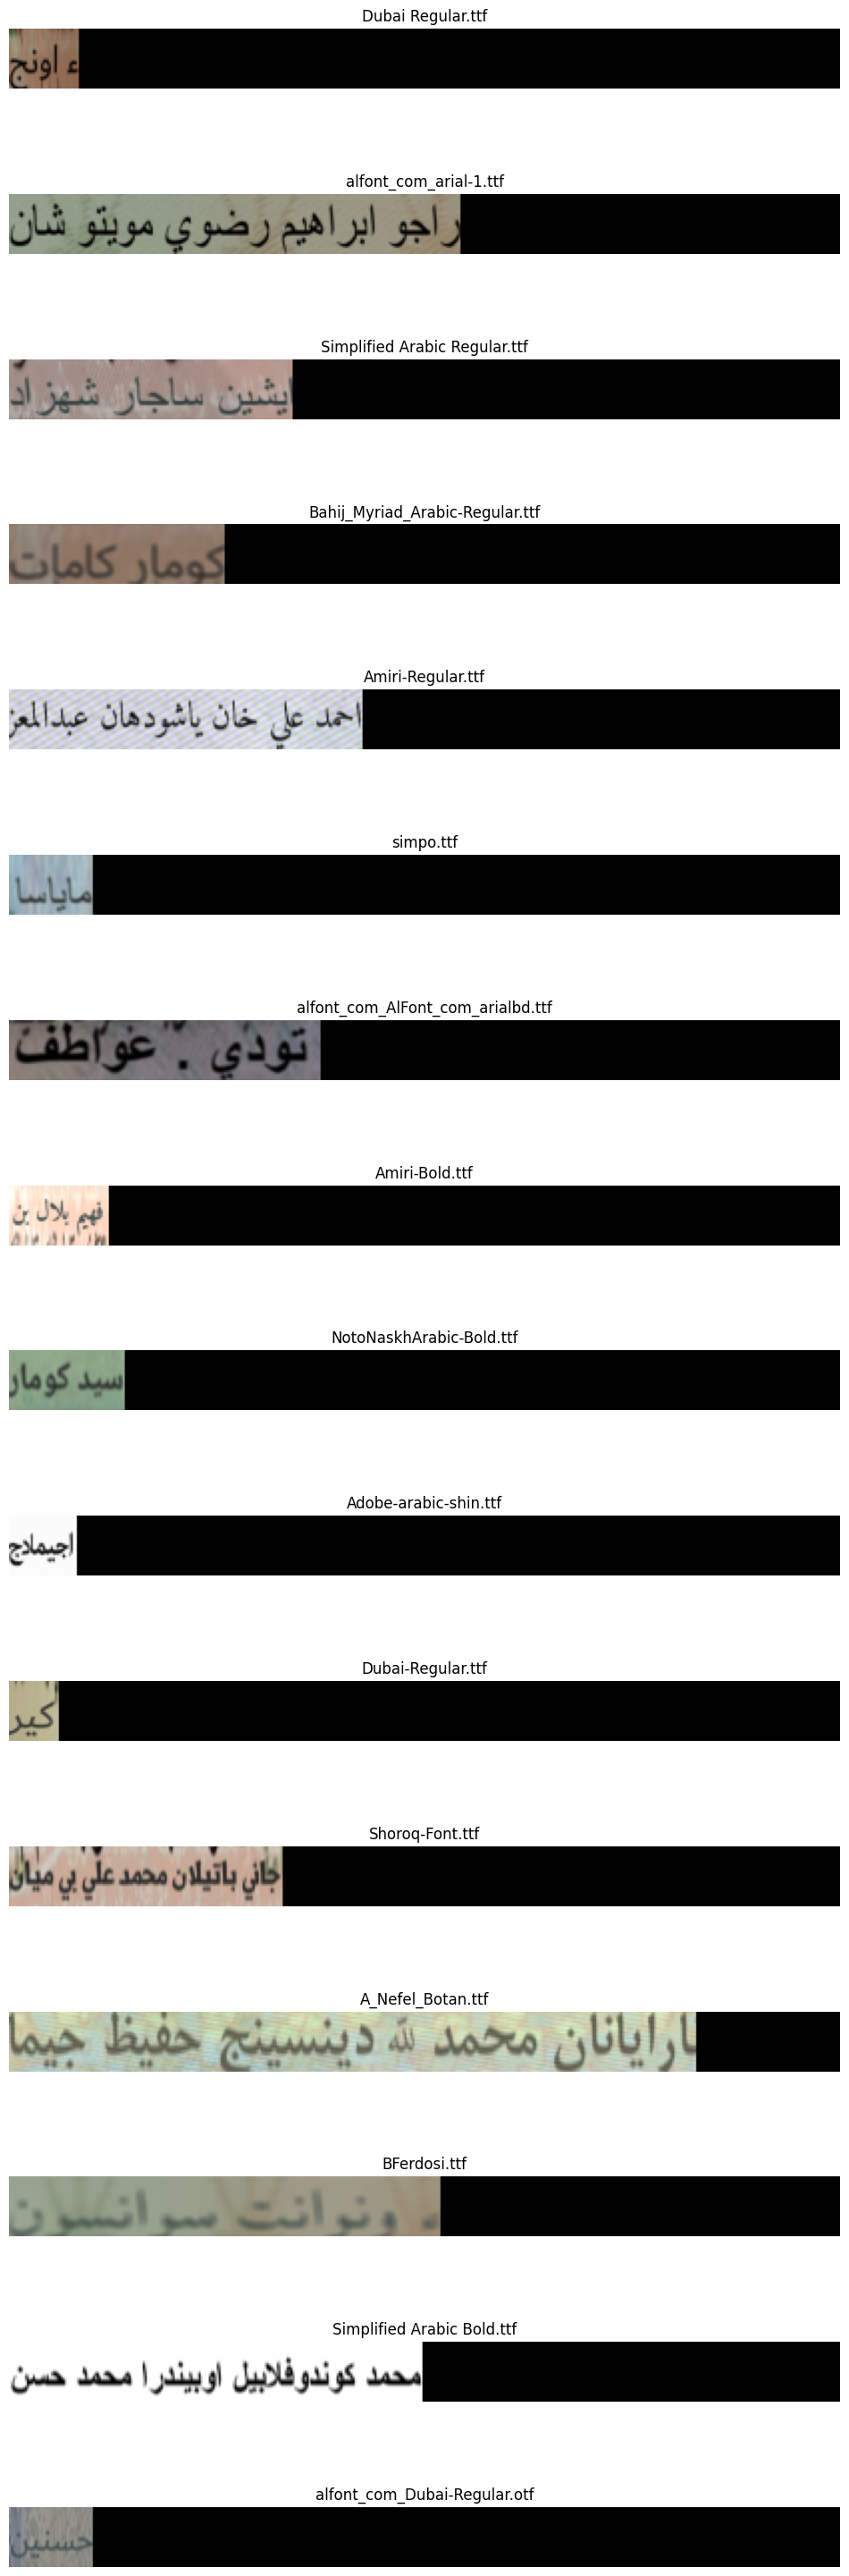

In [106]:
import arabic_reshaper
from bidi.algorithm import get_display


# list of font types to exclude
FONTS_LIST = []
FONTS_WEIGHTS = []
for path, subdirs, files in os.walk(FONTS_PATH):
    for name in files:
        font_path = os.path.join(path, name)
        basepath, ext = os.path.splitext(font_path)
        if ext != ".Identifier":
            if "Amiri" in font_path:
                FONTS_WEIGHTS.append(3)
            else:
                FONTS_WEIGHTS.append(1)
            FONTS_LIST.append(font_path)

print("Num Fonts:", len(FONTS_LIST))

plt.figure(figsize=(12, 38))
for i, font_path in enumerate(FONTS_LIST):
    text = "حنان بنت عبدالله بن سالم العبورية محمد"
    # text = "هدى عبدالعزيز جاسم احمد النشيط"
    # text = "موسى نغمان صالح محمد"
    # text = "ابراهيم بن عبدالعزيز بن سليمان الطريقي"
    # text = "محمد بن أحمد بن ناصر الراشدي"
    # text = "ابراهيم احمد مناور الزهام"
    # text = "الإسم: محمد فايز حامد حجاج" + ' '.join(PUNCTUATIONS)
    text, img = get_sample(
        MAX_NUM_WORDS, FONTS_LIST, text=None, two_lined_samples=False, font_path=font_path, font_size=48, font_weights=FONTS_WEIGHTS
    )
    ax = plt.subplot(len(FONTS_LIST), 1, i + 1)
    img = Image.fromarray(resizeAndPadImage(np.array(img)))
    plt.imshow(img)
    
    text = get_display(arabic_reshaper.reshape(os.path.split(font_path)[1]))
    plt.title(text)
    plt.axis("off")
plt.show()

## Generate Data Samples

In [6]:
from tqdm import tqdm
from atpbar import atpbar
import os
import multiprocessing
from threading import Thread


NUMBER_IMAGES_TO_GENERATE = 100000
TRAIN_TEST_SPLIT_PERCENTAGE = 0.1
NUMBER_THREADS = 10

os.makedirs(os.path.join(OUTPUT_TEST_PATH, "images"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_TRAIN_PATH, "images"), exist_ok=True)
    

def generate__(pid, num_images, train_path, test_path, max_words, fonts_list, test_split, font_weights):
    train_writer = open(os.path.join(train_path, f"{pid}_gt.txt"), "w", encoding="utf8")
    test_writer = open(os.path.join(test_path, f"{pid}_gt.txt"), "w", encoding="utf8")
    for image_index in atpbar(range(num_images), name=f'Job {pid}'):
        text, img = get_sample(
            max_words, 
            fonts_list, 
            two_lined_samples=False,
            font_size=48,
            font_weights=font_weights
        )
        image_name = f"{pid}_{image_index}_Synthetic_En.jpg"
        if image_index % int(1/test_split) == 0:
            # put in test
            image_path = os.path.join(test_path, "images", image_name)
            img.convert('RGB').save(image_path)
            test_writer.write(f"{image_name}\t{text}\n")
        else:
            # put in train
            image_path = os.path.join(train_path, "images", image_name)
            img.convert('RGB').save(image_path)
            train_writer.write(f"{image_name}\t{text}\n")
    train_writer.close()
    test_writer.close()


if __name__ == "__main__":
    processes = []
    num_images_per_process = int(NUMBER_IMAGES_TO_GENERATE / NUMBER_THREADS)
    remain_images = NUMBER_IMAGES_TO_GENERATE % NUMBER_THREADS

    threads = [None] * NUMBER_THREADS
    for pid in range(NUMBER_THREADS):
        threads[pid] = Thread(
            target=generate__, 
            args=(
                pid,
                (num_images_per_process + remain_images) if pid == 0 else num_images_per_process,
                OUTPUT_TRAIN_PATH,
                OUTPUT_TEST_PATH,
                MAX_NUM_WORDS,
                FONTS_LIST,
                TRAIN_TEST_SPLIT_PERCENTAGE,
                FONTS_WEIGHTS
            )
        )
        threads[pid].start()
    
    # join threads
    for thread in threads:
        thread.join()
        
    print("Merging GTs...")
    train_writer = open(os.path.join(OUTPUT_TRAIN_PATH, "gt.txt"), "w", encoding="utf8")
    test_writer = open(os.path.join(OUTPUT_TEST_PATH, "gt.txt"), "w", encoding="utf8")    
    train_records, test_records = 0, 0
    for path in [OUTPUT_TRAIN_PATH, OUTPUT_TEST_PATH]:
        for pid in range(NUMBER_THREADS):
            with open(os.path.join(path, f"{pid}_gt.txt"), "r", encoding="utf8") as reader:
                for line in reader.readlines():
                    if "train" in path:
                        train_writer.write(line)
                        train_records += 1
                    else:
                        test_writer.write(line)
                        test_records += 1                    
    train_writer.close()
    test_writer.close()
    
    # remove other GTs
    for path in [OUTPUT_TRAIN_PATH, OUTPUT_TEST_PATH]:
        for pid in range(NUMBER_THREADS):
            os.remove(os.path.join(path, f"{pid}_gt.txt"))
            
    print(f"Number of Train records {train_records}")
    print(f"Number of Test records {test_records}")

/tmp/ipykernel_18798/3910287383.py:160: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  img_w, img_h = font.getsize(text)


VBox()

Merging GTs...
Number of Train records 90000
Number of Test records 10000


## Combine Datasets

In [24]:
import shutil
import glob

DATASET_1_PATH = "Datasets/ARABIC/Synthetic_Rec_Ar_V7"
DATASET_2_PATH = "/mnt/d/EFR_WorkSpace/TRAINING/YOLOv8_training/raw_datasets/OCR_CROPS_ARABIC_MONGO/EIDs/fullNameLocal"
OUTPUT_DATASET_PATH = "Datasets/ARABIC/Synthetic_Rec_Ar_V7_IDA_EIDs"
TEST_PRECENTAGE = 0.1

annotations = []
count = 0
for path in [DATASET_1_PATH, DATASET_2_PATH]:
    for gt_path in glob.glob(os.path.join(path, "**", "*.txt"), recursive=True):
        base_path, file_name = os.path.split(gt_path)
        if file_name != "gt.txt":
            continue

        with open(gt_path, "r", encoding='utf8') as reader:
            for line in reader.readlines():
                image_name, text = line.strip().split(".jpg")
                image_name = image_name.strip() + ".jpg"
                text = text.strip()         
                annotations.append([base_path, image_name, text])

random.shuffle(annotations)
split = int(len(annotations) * TEST_PRECENTAGE)
print(f"Train Set images: {len(annotations) - split}")
print(f"Test Set images: {split}")
    
OUTPUT_TRAIN_PATH = os.path.join(OUTPUT_DATASET_PATH, "train")
OUTPUT_TEST_PATH = os.path.join(OUTPUT_DATASET_PATH, "test")
os.makedirs(os.path.join(OUTPUT_TRAIN_PATH, "images"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_TEST_PATH, "images"), exist_ok=True)

print("Copying train data...")
train_writer = open(os.path.join(OUTPUT_TRAIN_PATH, "gt.txt"), "w")
for (base_path, image_name, text) in tqdm(annotations[split:]):
    img_path = os.path.join(base_path, "images", image_name)
    if os.path.exists(img_path):
        shutil.copy(img_path, os.path.join(OUTPUT_TRAIN_PATH, "images", image_name))
        train_writer.write(f"{image_name}\t{text}\n")
train_writer.close()

print("Copying test data...")
test_writer = open(os.path.join(OUTPUT_TEST_PATH, "gt.txt"), "w")
for base_path, image_name, text in tqdm(annotations[:split]):
    img_path = os.path.join(base_path, "images", image_name)
    if os.path.exists(img_path):
        shutil.copy(img_path, os.path.join(OUTPUT_TEST_PATH, "images", image_name))
        test_writer.write(f"{image_name}\t{text}\n")
test_writer.close()


print("All done...")

Train Set images: 197365
Test Set images: 21929
Copying train data...


100%|█████████████████████████████████████████████████████████████| 197365/197365 [2:19:48<00:00, 23.53it/s]


Copying test data...


100%|█████████████████████████████████████████████████████████████████| 21929/21929 [10:59<00:00, 33.24it/s]

All done...


In [16]:
from tqdm import tqdm
       
path = "/mnt/d/EFR_WorkSpace/TRAINING/YOLOv8_training/raw_datasets/OCR_CROPS_ARABIC_MONGO/EIDs/fullNameLocal"

gt_path = os.path.join(path, "gt - Copy.txt")
gt_new_path = os.path.join(path, "gt - Processed.txt")
images_path = os.path.join(path, "images")
IGNORE = ['\u0660', '\u0661', '\u0662', '\u0663', '\u0664', '\u0665', '\u066a', '\u06a4', '\u0666', '\u0668']

mapping__ = {
    "\u064a": ['\u06cc', '\u0626', '\u0649'],
    "\u0648": ["\u0624"],
    "\u0627": ['\u0623', '\u0625']
}
mapping = {}
for k, v in mapping__.items():
    if k == '':
        continue
    for item in v:
        mapping[item] = k

correct_labels = []
writer = open(gt_new_path, "w", encoding='utf8')
with open(gt_path, "r", encoding='utf8') as reader:
    for line in tqdm(reader.readlines()):
        image_name, text = line.split(".jpg")
        image_name = image_name.strip() + ".jpg"
        text = text.strip()

        image_path = os.path.join(images_path, image_name)
        ignore = False
        if os.path.exists(image_path):
            for c in text:
                if c in IGNORE:
                    ignore = True
                    break

        if ignore:
            continue
            
        # replace similar chars with others
        for char_2_map, map_char in mapping.items():
            text = text.replace(char_2_map, map_char)

        correct_labels.append(text)
        writer.write(f"{image_name}\t{text}\n")
writer.close()


unique_chars = []
for text in correct_labels:
    for c in text:
        if c not in unique_chars:
            unique_chars.append(c)
unique_chars = sorted(unique_chars)

100%|██████████████████████████████████████████████████████████████| 119379/119379 [04:30<00:00, 441.09it/s]


## Data Augmentation

In [128]:
import copy 
PATH = "/mnt/d/EFR_WorkSpace/TRAINING/YOLOv8_training/raw_datasets/OCR_CROPS_ARABIC_MONGO/GCC"
VIS = False


def augment(img):
    images = [img]
    resize_factor = random.uniform(0.3, 0.4)
    w, h = img.size
    new_size = (int(w * resize_factor), int(h * resize_factor))
    images.append(img.copy().resize(new_size))
    
    # stretching both sides
    new_h = h + int(h * random.uniform(0.3, 0.7))
    images.append(img.copy().resize((w, new_h)))
    new_h = h - int(h * random.uniform(0.2, 0.5))   
    images.append(img.copy().resize((w, new_h)))
    
    # crop randomly
    w, h = img.size
    x1 = random.uniform(0.008, 0.01) * w
    y1 = random.uniform(0.01, 0.15) * h
    x2 = w - (random.uniform(0.008, 0.01) * w)
    y2 = h - (random.uniform(0.01, 0.15) * h)
    images.append(img.copy().crop((x1, y1, x2, y2)))

    # add some opacity
    alpha_ = random.choice(images).copy()
    alpha_.putalpha(random.randint(150, 210))
    images.append(alpha_)

    # add more patterns
    images.append(add_moire_patterns(random.choice(images).copy(), alpha=random.uniform(0.1, 0.2)))
    
    # change brighness randomly
    enhancer = ImageEnhance.Brightness(random.choice(images).copy())
    images.append(enhancer.enhance(random.uniform(0.5, 1.5)))

    # apply blur
    images.append(guassianBlur(random.choice(images).copy()))
    images.append(motionBlur(random.choice(images).copy()))
    images.append(bokenBlur(random.choice(images).copy(), w))

    img__ = random.choice(images).copy()
    for op in random.choices([guassianBlur, motionBlur, bokenBlur], k=2):
        img__ = op(img__, w)
    images.append(img__)

    # rotate image
    for angle in list(set([random.choice([-1, 1]) * randint(1, 4) for _ in range(5)])):
        images.append(img.copy().rotate(angle))
            
    return images


correct_labels = []
# writer = open(os.path.join(PATH, "gt.txt"), "w", encoding='utf8')
plt.figure(figsize=(12, 38))

to_replace = {
    '\u0626': "\u064a",
    '\u0624': "\u0648",
    '\u0625': "\u0627",
    '\u0623': "\u0627",
    '\u0649': "\u064a",
}

ALL_IMAGES = []
with open(os.path.join(PATH, "gt.txt"), "r", encoding='utf8') as reader:
    for line in tqdm(reader.readlines()):
        image_name, text = line.split(".jpg")
        image_name = image_name.strip() + ".jpg"
        text = text.strip()
        image_path = os.path.join(os.path.join(PATH, "images"), image_name)
        ignore = False
        for tr, vr in to_replace.items():
            text = text.replace(tr, vr)
        if os.path.exists(image_path):
            ALL_IMAGES.append((image_path, text))
random.shuffle(ALL_IMAGES)

if not VIS:
    os.makedirs("Datasets/New folder/images", exist_ok=True)
    writer = open(os.path.join("Datasets/New folder", "gt.txt"), "w", encoding='utf8')
    for image_path, text in tqdm(ALL_IMAGES):
        basepath, image_name = os.path.split(image_path)
        img = Image.open(image_path)
        augmented_images = augment(img)
        for i, img in enumerate(augmented_images):
            img = img.convert('RGB')
            image_name__ = image_name.replace(".jpg", f"_{i}.jpg")
            save_dir = os.path.join("Datasets/New folder/images", image_name__)
            img.save(save_dir)
            writer.write(f"{image_name__}\t{text}\n")
    writer.close()
else:
    image_path = random.choice(ALL_IMAGES)[0]
    aumented_imaged = augment(Image.open(image_path))
    for i, img in enumerate(aumented_imaged):
        img = img.convert('RGB')
        ax = plt.subplot(len(aumented_imaged), 1, i + 1)
        img = Image.fromarray(resizeAndPadImage(np.array(img)))
        plt.imshow(img)

100%|████████████████████████████████████████████████████████████████████| 437/437 [00:04<00:00, 108.83it/s]


<Figure size 1200x3800 with 0 Axes>